# 自动编码器
自编码器是一种特殊类型的神经网络，经过训练可以将其输入复制到其输出。例如，给定手写数字的图像，自动编码器首先将图像编码为较低维度的潜在表示，然后将潜在表示解码回图像。自编码器学习压缩数据，同时最小化重建误差。

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

In [2]:
# 首先，您将使用 Fashion MNIST 数据集训练基本的自动编码器。该数据集中的每张图像都是 28x28 像素。


(x_train,_),(x_test,_) = fashion_mnist.load_data()
x_train = x_train.astype("float32")/255.
x_test = x_test.astype("float32")/255.

x_train.shape

4431872/4422102 [==============================] - 0s 0us/step


(60000, 28, 28)

In [3]:
x_test.shape

(10000, 28, 28)

**first example:基本自动编码器**
定义一个具有两个 Dense 层的自动编码器：aencoder将图像压缩为 64 维潜在向量，adecoder用于从潜在空间重建原始图像。



In [7]:
latent_dim = 64 

class Autoencoder(Model):
  def __init__(self, latent_dim):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim   
    self.encoder = tf.keras.Sequential([
      layers.Flatten(),
      layers.Dense(latent_dim, activation='relu'),
    ])
    self.decoder = tf.keras.Sequential([
      layers.Dense(784, activation='sigmoid'),
      layers.Reshape((28, 28))
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded



In [8]:
autoencoder = Autoencoder(latent_dim)

In [9]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [11]:
# autoencoder.summary()

x_train使用作为输入和目标来训练模型。将encoder学习将数据集从 784 维压缩到潜在空间，decoder并将学习重建原始图像。

In [12]:
autoencoder.fit(x_train,x_train,epochs=10,shuffle=True,validation_data=(x_test,x_test))

Epoch 1/10
1875/1875 [==============================] - 7s 2ms/step - loss: 0.0234 - val_loss: 0.0133
Epoch 2/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0115 - val_loss: 0.0104
Epoch 3/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0099 - val_loss: 0.0096
Epoch 4/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0094 - val_loss: 0.0093
Epoch 5/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0091 - val_loss: 0.0092
Epoch 6/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0090 - val_loss: 0.0090
Epoch 7/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0089 - val_loss: 0.0089
Epoch 8/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0088 - val_loss: 0.0090
Epoch 9/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0087 - val_loss: 0.0088
Epoch 10/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.008

现在模型已经训练好了，让我们通过对测试集中的图像进行编码和解码来测试它。



In [13]:
encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

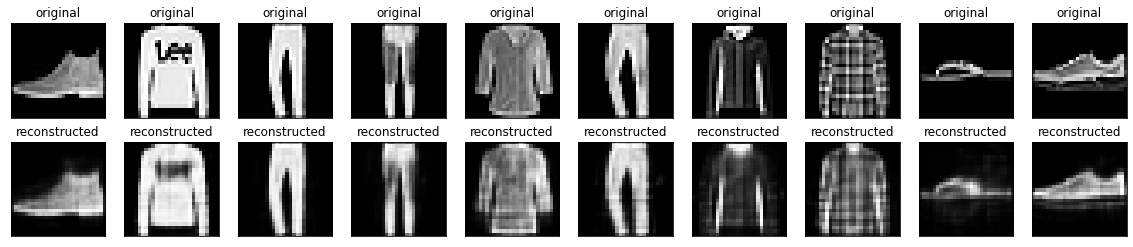

In [14]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(x_test[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs[i])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

**second example:图像去噪**
还可以训练自动编码器来去除图像中的噪声。在以下部分中，您将通过对每个图像应用随机噪声来创建时尚 MNIST 数据集的噪声版本。然后，您将使用噪声图像作为输入、原始图像作为目标来训练自动编码器。





In [15]:
# 重新导入数据
(x_train, _), (x_test, _) = fashion_mnist.load_data()


In [16]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

print(x_train.shape)

(60000, 28, 28, 1)


向图像中添加随机噪声

In [17]:
noise_factor = 0.2 
x_train_noisy = x_train+noise_factor*tf.random.normal(shape=x_train.shape)
x_test_noisy = x_test + noise_factor * tf.random.normal(shape=x_test.shape)

x_train_noisy = tf.clip_by_value(x_train_noisy,clip_value_min=0,clip_value_max=1.)
x_test_noisy = tf.clip_by_value(x_test_noisy,clip_value_min=0,clip_value_max=1.)

绘制嘈杂图像

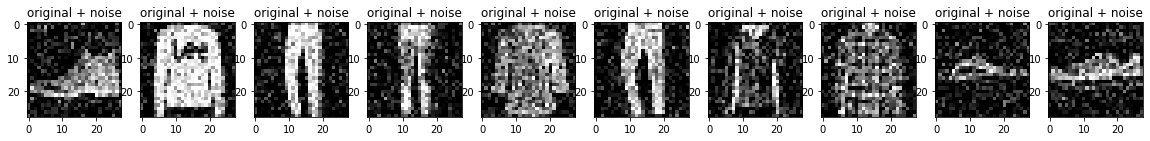

In [18]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
plt.show()

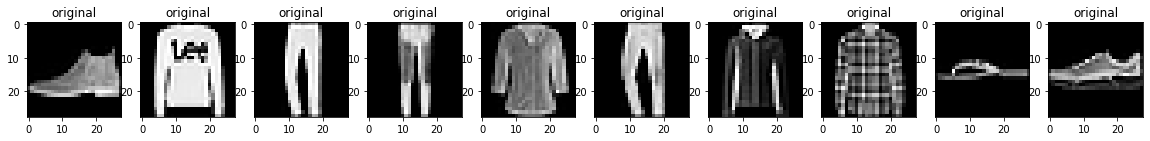

In [19]:
n = 10
# 原图
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.title("original")
    plt.imshow(tf.squeeze(x_test[i]))
    plt.gray()
plt.show()

定义一个卷积自动编码器

In [20]:
class Denoise(Model):
  def __init__(self):
    super(Denoise, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Input(shape=(28, 28, 1)),
      layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2),
      layers.Conv2D(8, (3, 3), activation='relu', padding='same', strides=2)])

    self.decoder = tf.keras.Sequential([
      layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding='same')])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Denoise()

In [21]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [22]:
autoencoder.fit(x_train_noisy, x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))

Epoch 1/10
1875/1875 [==============================] - 16s 4ms/step - loss: 0.0169 - val_loss: 0.0097
Epoch 2/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0090 - val_loss: 0.0087
Epoch 3/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0083 - val_loss: 0.0081
Epoch 4/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0079 - val_loss: 0.0078
Epoch 5/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0076 - val_loss: 0.0075
Epoch 6/10
1875/1875 [==============================] - 7s 3ms/step - loss: 0.0075 - val_loss: 0.0074
Epoch 7/10
1875/1875 [==============================] - 7s 3ms/step - loss: 0.0073 - val_loss: 0.0074
Epoch 8/10
1875/1875 [==============================] - 7s 3ms/step - loss: 0.0072 - val_loss: 0.0072
Epoch 9/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0072 - val_loss: 0.0072
Epoch 10/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.00

In [23]:
autoencoder.encoder.summary()
# 让我们看一下编码器的摘要。请注意图像是如何从 28x28 下采样到 7x7 的。



Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 16)        160       
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 8)           1160      
                                                                 
Total params: 1,320
Trainable params: 1,320
Non-trainable params: 0
_________________________________________________________________


In [24]:
# 解码器将图像从7x7上采样回28x28
autoencoder.decoder.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_transpose (Conv2DTra  (None, 14, 14, 8)        584       
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 16)       1168      
 ranspose)                                                       
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 1)         145       
                                                                 
Total params: 1,897
Trainable params: 1,897
Non-trainable params: 0
_________________________________________________________________


绘制由自动编码器产生的噪声图像和去噪图像。



In [25]:
encoded_imgs = autoencoder.encoder(x_test_noisy).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()


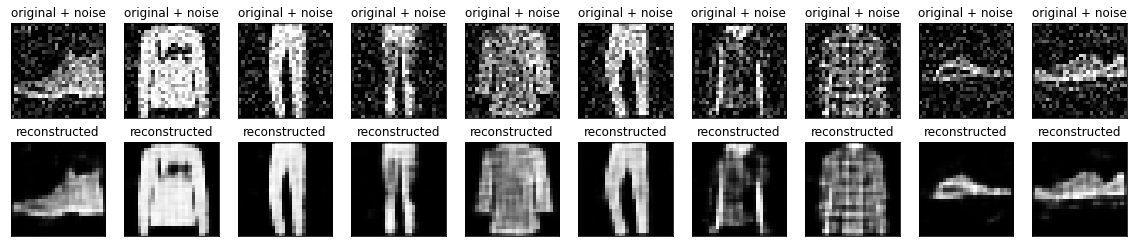

In [26]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):

    # display original + noise
    ax = plt.subplot(2, n, i + 1)
    plt.title("original + noise")
    # 噪声图片
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    bx = plt.subplot(2, n, i + n + 1)
    # 去噪图片
    plt.title("reconstructed")
    plt.imshow(tf.squeeze(decoded_imgs[i]))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)

    # 和原图对比一下
    # cx = plt.subplot(2, n, i + n )
    # plt.title("original")
    # plt.imshow(tf.squeeze(x_test[i]))
    # plt.gray()
    # bx.get_xaxis().set_visible(False)
    # bx.get_yaxis().set_visible(False)



plt.show()

**third example:异常检测**
在此示例中，您将训练自动编码器以检测ECG5000 数据集上的异常情况。该数据集包含 5,000个心电图，每个有 140 个数据点。您将使用数据集的简化版本，其中每个示例都被标记为0（对应于异常节奏）或1（对应于正常节奏）。您对识别异常节律感兴趣。



In [27]:
# 加载数据
# Download the dataset
dataframe = pd.read_csv('http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv', header=None)
raw_data = dataframe.values
dataframe.head()

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1.0


In [28]:
# 标签包含在csv最后的一列
labels = raw_data[:,-1]

# 其他數據點為心電圖數據
data = raw_data[:,0:-1]

train_data,test_data ,train_labels,test_labels = train_test_split(
    data,labels,test_size=0.2,random_state=21
)

In [29]:
# 将数据标准化为[0,1]
'''表明当输入值介于 0 和 1 之间（或具有零均值和单位方差）时，神经网络通常训练得更好。
其次，缩放数据支持自动编码器的学习目标（最小化重建误差）并使结果更具可解释性。'''
min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)

train_data = (train_data - min_val)/(max_val - min_val)
test_data = (test_data - min_val)/(max_val - min_val)

train_data = tf.cast(train_data,tf.float32)
test_data = tf.cast(test_data,tf.float32)

您将仅使用正常节奏训练自动编码器，这些节奏在此数据集中标记为1。将正常节律与异常节律分开。



In [30]:
train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)

normal_train_data =train_data[train_labels]
normal_test_data = test_data[test_labels]

anomalous_train_data = train_data[~train_labels]
anomalous_test_data = test_data[~test_labels]

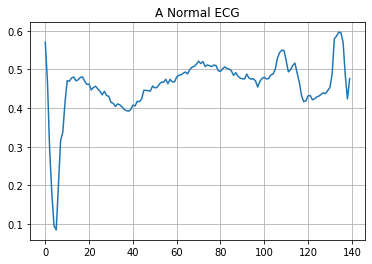

In [31]:
# 绘制正常心电图
plt.grid()
plt.plot(np.arange(140), normal_train_data[0])
plt.title("A Normal ECG")
plt.show()

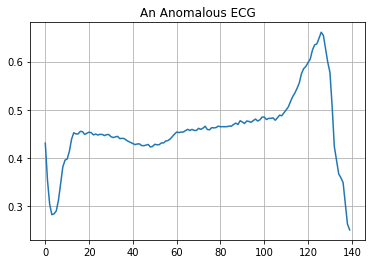

In [32]:
# 绘制异常心电图
plt.grid()
plt.plot(np.arange(140), anomalous_train_data[0])
plt.title("An Anomalous ECG")
plt.show()

In [33]:
# 建立模型
class AnomalyDetector(Model):
  def __init__(self):
    super(AnomalyDetector,self).__init__()
    self.encoder = tf.keras.Sequential([
        layers.Dense(32,activation='relu'),
        layers.Dense(16,activation='relu'),
        layers.Dense(8,activation='relu')
    ])

    self.decoder =tf.keras.Sequential([
        layers.Dense(16,activation='relu'),
        layers.Dense(32,activation='relu'),
        layers.Dense(140,activation='sigmoid'),
    ])

  def call(self,x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded
autoencoder = AnomalyDetector()

In [34]:
autoencoder.compile(optimizer='adam', loss='mae')

In [35]:
# 请注意，自动编码器仅使用正常 ECG 进行训练，但使用完整测试集进行评估。

history = autoencoder.fit(normal_train_data, normal_train_data, 
          epochs=20, 
          batch_size=512,
          validation_data=(test_data, test_data),
          shuffle=True)

Epoch 1/20
5/5 [==============================] - 1s 37ms/step - loss: 0.0588 - val_loss: 0.0530
Epoch 2/20
5/5 [==============================] - 0s 8ms/step - loss: 0.0554 - val_loss: 0.0512
Epoch 3/20
5/5 [==============================] - 0s 12ms/step - loss: 0.0528 - val_loss: 0.0493
Epoch 4/20
5/5 [==============================] - 0s 8ms/step - loss: 0.0488 - val_loss: 0.0479
Epoch 5/20
5/5 [==============================] - 0s 9ms/step - loss: 0.0447 - val_loss: 0.0454
Epoch 6/20
5/5 [==============================] - 0s 8ms/step - loss: 0.0405 - val_loss: 0.0428
Epoch 7/20
5/5 [==============================] - 0s 10ms/step - loss: 0.0367 - val_loss: 0.0412
Epoch 8/20
5/5 [==============================] - 0s 11ms/step - loss: 0.0336 - val_loss: 0.0395
Epoch 9/20
5/5 [==============================] - 0s 8ms/step - loss: 0.0311 - val_loss: 0.0387
Epoch 10/20
5/5 [==============================] - 0s 8ms/step - loss: 0.0292 - val_loss: 0.0377
Epoch 11/20
5/5 [==================

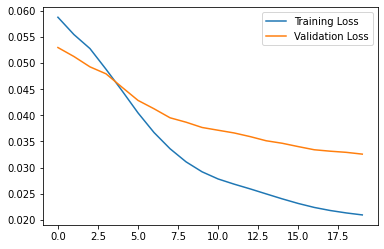

In [36]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()


如果重建误差大于正常训练示例的一个标准偏差，您很快就会将 ECG 归类为异常。首先，让我们从训练集中绘制一个正常的心电图，它被自动编码器编码和解码后的重建，以及重建误差。



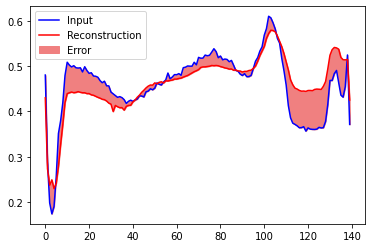

In [37]:
encoded_data = autoencoder.encoder(normal_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.plot(normal_test_data[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(140), decoded_data[0], normal_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

创建一个类似的图，是一个异常测试示例

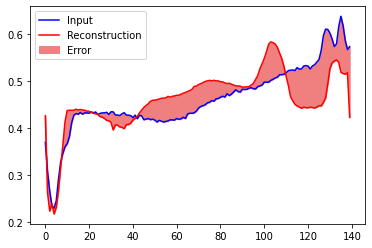

In [38]:
encoded_data = autoencoder.encoder(anomalous_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.plot(anomalous_test_data[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(140), decoded_data[0], anomalous_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

# 检测异常
通过计算重建损失是否大于固定阈值来检测异常。在本教程中，您将计算训练集中正常示例的平均平均误差，然后如果重构误差高于训练集的一个标准偏差，则将未来示例分类为异常。



In [39]:
# 绘制训练集中正常心电图的重建误差
reconstructions = autoencoder.predict(normal_train_data)
train_loss = tf.keras.losses.mae(reconstructions,normal_train_data)

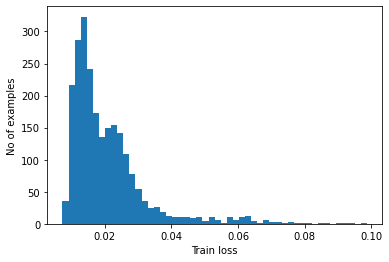

In [40]:
plt.hist(train_loss[None,:], bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

In [41]:
# 选择一个比平均值高一个标准差的阈值
'''当前的设置是半监督的，因为我们有一小部分验证/测试样本的标签。
使用这些标签（和一些领域专业知识），我们可以自动确定这个阈值——我们探索验证集中每个数据点的 
MSE 值范围，并选择我们的阈值作为产生最佳准确性的点。
'''
threshold = np.mean(train_loss)+np.std(train_loss)
threshold

0.032596882

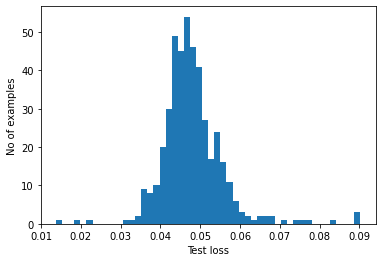

In [42]:
# 如果您检查测试集中异常示例的重建误差，您会注意到大多数的重建误差大于阈值。
# 通过改变阈值，您可以调整分类器的精度和召回率。

reconstructions = autoencoder.predict(anomalous_test_data)
test_loss = tf.keras.losses.mae(reconstructions, anomalous_test_data)

plt.hist(test_loss[None, :], bins=50)
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()

如果重建误差大于阈值，则将 ECG 分类为异常。

In [43]:
def predict(model, data, threshold):
  reconstructions = model(data)
  loss = tf.keras.losses.mae(reconstructions, data)
  return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
  print("Accuracy = {}".format(accuracy_score(labels, predictions)))
  print("Precision = {}".format(precision_score(labels, predictions)))
  print("Recall = {}".format(recall_score(labels, predictions)))

In [44]:
preds = predict(autoencoder, test_data, threshold)
print_stats(preds, test_labels)

Accuracy = 0.942
Precision = 0.9921568627450981
Recall = 0.9035714285714286
